In [38]:
import numpy as np
import time
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [39]:
#fetch the mnist dataset
x, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
print(x.shape,y.shape)

(70000, 784) (70000,)


In [40]:
#x_n = x.to_numpy()
x_n = x
#y_n = y.to_numpy()
y_n = y

In [41]:
y_n = y_n.astype('int') #convert output to integers 0-9
x_norm = x_n/255.0 #normalise input data
x_train, x_val, y_train, y_val = train_test_split(x_norm, y_n, test_size=0.1, random_state=42) #split the data into train and validation
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

x_train = x_train.T #take the transpose of the training data m*784 -> 784*m
x_val = x_val.T #take the transpose of the test data m*784 -> 784*m
print(x_train.shape, x_val.shape)

(63000, 784) (7000, 784) (63000,) (7000,)
(784, 63000) (784, 7000)


In [42]:
def saveText(fPath, arr):
    #dim1, dim2 = arr.shape
    f = open(fPath, 'a')
    np.savetxt(f, arr.flatten(), newline = ', ')
    f.write("\n")
    f.close()

In [43]:
#have to change with different number of layers
def params_init():

  #np.random.seed(2)
  W1 = np.random.rand(500,784) - 0.5
  b1 = np.random.rand(500,1) - 0.5
  W2 = np.random.rand(500,500) - 0.5
  b2 = np.random.rand(500,1) - 0.5
  W3 = np.random.rand(10,500) - 0.5 
  b3 = np.random.rand(10,1) - 0.5
  #W4 = np.random.rand(50,200) - 0.5   
  #b4 = np.random.rand(50,1) - 0.5    
  #W5 = np.random.rand(10,50) - 0.5  
  #b5 = np.random.rand(10,1) - 0.5    
  print("Params Initialised")

  return (W1, b1, W2, b2, W3, b3)


#have to change with different number of layers
def forward(x_train, W1, b1, W2, b2, W3, b3):
  #print("Entered FP")
  Z1 = np.matmul(W1,x_train) + b1 #W1 is 50*784, x_train is 748*m, Z1 is 50*m
  A1 = relu(Z1)

  Z2 = np.matmul(W2,A1) + b2 
  A2 = relu(Z2)

  Z3 = np.matmul(W3,A2) + b3
  A3 = softmax(Z3)
  
  #Z4 = np.matmul(W4,A3) + b4
  #A4 = relu(Z4)

  #Z5 = np.matmul(W5,A4) + b5
  #A5 = softmax(Z5)

  #W2 is 10*50, A1 is 50*m
  # print(np.exp(Z2))
  # print(np.sum(np.exp(Z2)))

  #A2 is 10*m, final predictions
  # print("Fp Done")

  return Z1, A1, Z2, A2, Z3, A3


def relu(x):
   return np.maximum(x,0)


def softmax(Z):
  return np.exp(Z) / np.sum(np.exp(Z),0)


def relu_d(x):
  return x>0


def one_hot_encoding(y):
  shape = (y.shape[0], 10)
  one_hot = np.zeros(shape)
  rows = np.arange(y.size)
  one_hot[rows, y] = 1
  return one_hot.T


#have to change with different number of layers
def backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, y):
  # print("Entered Backprop")
  m = y.shape[0] #m is the number of training examples
  Y = one_hot_encoding(y)

  dZ3 = (A3 - Y)
  
  dW3 = 1/m*np.matmul(dZ3,A2.T)

  db3 = 1/m*np.sum(dZ3, axis=1)

  dZ2 = np.matmul(W3.T, dZ3)*relu_d(Z2) #W2 is 10*50, dZ2 = 10*m, dZ1 = 50*m

  dW2 = 1/m*np.matmul(dZ2,A1.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db2 = 1/m*np.sum(dZ2, axis=1) #db1 is 50*1

  dZ1 = np.matmul(W2.T, dZ2)*relu_d(Z1) #W2 is 10*50, dZ2 = 10*m, dZ1 = 50*m

  dW1 = 1/m*np.matmul(dZ1,X.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db1 = 1/m*np.sum(dZ1, axis = 1) #db1 is 50*1


  return dW1, db1, dW2, db2, dW3, db3


#have to change with different number of layers
def param_update(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, lr):

  #updates the parameters based on backpropogation

  W1 = W1 - lr*dW1
  b1 = b1 - lr*(db1.reshape(b1.shape))
  W2 = W2 - lr*dW2
  b2 = b2 - lr*(db2.reshape(b2.shape))
  W3 = W3 - lr*dW3
  b3 = b3 - lr*(db3.reshape(b3.shape))
  #W4 = W4 - lr*dW4
  #b4 = b4 - lr*db4

  return W1, b1, W2, b2, W3, b3


#have to change with different number of layers
def batch_grad_descent(X,Y,iter, lr, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  mu = 1
  sigma = 0.4

  W1, b1, W2, b2, W3, b3 = params_init()
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)


  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0


    #storing the weights:
    start = time.time()
    basePath = "D:\\perturbation_on_chip_learning\\Perturbation-techniques-in-CNNs\\weights\\"
    saveText(basePath+"W1.txt", W1)
    saveText(basePath+"W2.txt", W2)
    saveText(basePath+"W3.txt", W3)
    saveText(basePath+"b1.txt", b1)
    saveText(basePath+"b2.txt", b2)
    saveText(basePath+"b3.txt", b3)
    end = time.time()
    print("###Saving weights : {time}".format(time = end - start))


    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes

      Z1, A1, Z2, A2, Z3, A3 = forward(X1, W1, b1, W2, b2, W3, b3) 

      dW1, db1, dW2, db2, dW3, db3 = backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X1, Y1)


      W1, b1, W2, b2, W3, b3 = param_update(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, lr = lr)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _, _, _, A3_train = forward(X, W1, b1, W2, b2, W3, b3)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A3_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _, _, _,  A3_val = forward(x_val, W1, b1, W2, b2, W3, b3)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A3_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return W1, b1, W2, b2, W3, b3, train_acc, val_acc, train_loss, val_loss, sum_weights




def grad_descent(X,Y,iter, lr, print_op, decay_factor=0):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  mu = 1
  sigma = 0.4

  W1, b1, W2, b2, W3, b3 = params_init()
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)


  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0
    X1, Y1 = X.T, Y
    X1 = X1.T #take transpose to match the sizes

    Z1, A1, Z2, A2, Z3, A3 = forward(X1, W1, b1, W2, b2, W3, b3) 

    dW1, db1, dW2, db2, dW3, db3 = backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X1, Y1)

    W1, b1, W2, b2, W3, b3 = param_update(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, lr = lr, factor = decay_factor)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _, _, _, A3_train = forward(X, W1, b1, W2, b2, W3, b3)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A3_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _, _, _,  A3_val = forward(x_val, W1, b1, W2, b2, W3, b3)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A3_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return W1, b1, W2, b2, W3, b3, train_acc, val_acc, train_loss, val_loss, sum_weights


def predictions(A):
  #argmax returns the index of maximum value, we will feed the sigmoid output to this function 
  return np.argmax(A,0)


def accuracy(A,Y):
  #this will compare the predicted output to the ground truth
  return np.sum(A == Y)/Y.shape[0]*100


In [44]:
epochsToTrain = 100 #please update the rest of the functions with this since I have hardcoded them for now

In [45]:
answerToClear = input("Do you want to clear the weights of the model from the text files? ")
if answerToClear.lower().strip()=='yes':
    basePath = "D:\\perturbation_on_chip_learning\\Perturbation-techniques-in-CNNs\\weights\\"
    fileToClear = open(basePath+"W1.txt", "w")
    fileToClear.write("")
    fileToClear.close()
    fileToClear = open(basePath+"W2.txt", "w")
    fileToClear.write("")
    fileToClear.close()
    fileToClear = open(basePath+"W3.txt", "w")
    fileToClear.write("")
    fileToClear.close()
    fileToClear = open(basePath+"b1.txt", "w")
    fileToClear.write("")
    fileToClear.close()
    fileToClear = open(basePath+"b2.txt", "w")
    fileToClear.write("")
    fileToClear.close()
    fileToClear = open(basePath+"b3.txt", "w")
    fileToClear.write("")
    fileToClear.close()
    print("Weights of the model HAVE been cleared!!")
else:
    print("Weights of the model have NOT been cleared. You can use those weights!!")

Variability transformed weights HAVE been cleared!!


In [46]:
answerToTrain = input("Do you want to train the model again? : ")
if answerToTrain.strip().lower()=='yes':
    W1, b1, W2, b2, W3, b3, train_acc, val_acc, train_loss, val_loss, sum_weights = batch_grad_descent(x_train,y_train,epochsToTrain, 0.01,1)

Params Initialised
###Saving weights : 1.614595890045166
Iteration: 1
Train accuracy: 82.86349206349206
Val accuracy: 82.64285714285714
###Saving weights : 2.1107051372528076
Iteration: 2
Train accuracy: 86.61428571428571
Val accuracy: 85.82857142857144
###Saving weights : 1.699385166168213
Iteration: 3
Train accuracy: 88.3873015873016
Val accuracy: 87.4
###Saving weights : 1.698133945465088
Iteration: 4
Train accuracy: 89.46507936507938
Val accuracy: 88.22857142857143
###Saving weights : 1.5742156505584717
Iteration: 5
Train accuracy: 90.19365079365079
Val accuracy: 88.9
###Saving weights : 1.6465246677398682
Iteration: 6
Train accuracy: 90.9047619047619
Val accuracy: 89.44285714285715
###Saving weights : 1.576500654220581
Iteration: 7
Train accuracy: 91.45238095238095
Val accuracy: 89.71428571428571
###Saving weights : 1.652557134628296
Iteration: 8
Train accuracy: 91.82222222222222
Val accuracy: 89.85714285714286
###Saving weights : 1.636361837387085
Iteration: 9
Train accuracy: 92.

In [47]:
def loadFromLine(line, shape):
    #line = "xx, xxx, x,....., "
    lineElements = np.array([float(x) for x in line.split(", ")[:-1]]).reshape(shape)
    return lineElements

In [48]:
def getVth(mu, sigma, shape):
  #last dimension represents the binary rep for each weight
  return np.random.normal(loc=mu, scale=sigma, size=shape) #each bit is represented by an sram so we need those many vth values for each mosfet in this set

In [109]:
def initMosParam(shape, mu, sigma, vDD, precision):
    dim1, dim2 = shape
    sizeI = (dim1, dim2, precision)

    Vth = getVth(mu, sigma, sizeI)#get the array of Vth values 

    iOn = ((vDD - Vth)**2)*1e-06#scaling the current according to Ioff values arbitraryfor now!!


    iOnNominal = 1e-06*(vDD**2 - (2*vDD*mu) + (sigma**2  + mu**2))


    iOff = np.random.uniform(low=0, high=1e-10, size = sizeI)#no negative value
    return (iOn, iOnNominal, iOff)

In [106]:
def weightTransformWithVariability(weightArray, currents, precision, step, discreteSteps):
  dim1, dim2 = weightArray.shape
  sizeI = (dim1, dim2, precision)

  clippedWeightIndexArray = np.digitize(np.abs(weightArray), discreteSteps) #finds the index value of the weights

  #vDD = 5
  #mu = 0.7#mean of the distribution
  #sigma = 0.00001
  #! work with sigma/mu
  
  iOn, iOnNominal, iOff = currents

  
  analogWeightArray = np.zeros_like(weightArray, dtype=float)

  for bitLevel in range(precision):
    analogWeightArray += np.sign(weightArray) * np.where(np.bitwise_and(clippedWeightIndexArray, 2**bitLevel)>=1, iOn[:, :, bitLevel], iOff[:, :, bitLevel]) * (2**bitLevel)



  weightWithVariability = (analogWeightArray/iOnNominal)*step
  return weightWithVariability

In [50]:
#defines the printing function for progress bar etc
import sys
def show(j,  count, size=60, prefix = "", out=sys.stdout):
        x = int(size*j/count)
        print("{}[{}{}] {}/{}".format(prefix, u"█"*x, "."*(size-x), j, count), end='\r', file=out, flush=True)

In [112]:
def readWriteTransform(readPath, writePath, shape, precision, step, discreteSteps, epochsToTrain, currents):
    #basePath = "D:\\perturbation_on_chip_learning\\Perturbation-techniques-in-CNNs\\weights\\"
    fileOpen = open(readPath, 'r')
    iter = 1
    for line in fileOpen:
        start = time.time()
        saveText(writePath, weightTransformWithVariability(loadFromLine(line, shape), currents, precision, step, discreteSteps))
        end = time.time()
        #print("#Finished reading and transforming Line {lineNo} with Time taken = {tTime}".format(lineNo = iter, tTime = end-start))
        show(iter, epochsToTrain, 100, "Processing.....Time taken = {tTime} | ".format(lineNo = iter, tTime = round(end-start,2)))
        iter += 1
        
    fileOpen.close()
    print("##Fin.##")

# Setting up the variability conditions

In [179]:
precision = 10#setting the precision value of the calculations

In [180]:
wRange = 3

In [181]:
noOfLevels = 2**precision - 1 #no of levels of quantization

In [182]:
step = round(wRange/noOfLevels, precision) #step size of each of the step after quantization

In [183]:
discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps

## Clearing out the variability transformed weights text files for storing the new transformed weights

In [121]:
answer = input("Your response to clear variability transformed weight text files : ")
if answer.lower().strip()=='yes':
    basePath = "D:\\perturbation_on_chip_learning\\Perturbation-techniques-in-CNNs\\weights\\"
    fileToClear = open(basePath+"W1var.txt", "w")
    fileToClear.write("")
    fileToClear.close()
    fileToClear = open(basePath+"W2var.txt", "w")
    fileToClear.write("")
    fileToClear.close()
    fileToClear = open(basePath+"W3var.txt", "w")
    fileToClear.write("")
    fileToClear.close()
    fileToClear = open(basePath+"b1var.txt", "w")
    fileToClear.write("")
    fileToClear.close()
    fileToClear = open(basePath+"b2var.txt", "w")
    fileToClear.write("")
    fileToClear.close()
    fileToClear = open(basePath+"b3var.txt", "w")
    fileToClear.write("")
    fileToClear.close()
    print("Variability transformed weights HAVE been cleared!!")
else:
    print("Variability transformed weights have NOT been cleared. You can use those weights!!")

Variability transformed weights HAVE been cleared!!


## Storing the variability transformed weights in the appropriate text files

In [122]:
mu, sigma, vDD = 0.7, 0.7, 5

In [123]:
W1Currents = initMosParam((500, 784), mu, sigma, vDD, precision)
b1Currents = initMosParam((500, 1), mu, sigma, vDD, precision)
W2Currents = initMosParam((500, 500) ,mu, sigma, vDD, precision)
b2Currents = initMosParam((500, 1), mu, sigma, vDD, precision)
W3Currents = initMosParam((10, 500),mu, sigma, vDD, precision)
b3Currents = initMosParam((10, 1), mu, sigma, vDD, precision)

In [124]:
basePath = "D:\\perturbation_on_chip_learning\\Perturbation-techniques-in-CNNs\\weights\\"
readWriteTransform(basePath+"W1.txt", basePath+"W1var.txt", (500, 784), precision, step, discreteSteps, epochsToTrain, W1Currents)

##Fin.##ng.....Time taken = 1.27 | [████████████████████████████████████████████████████████████████████████████████████████████████████] 100/100


In [125]:
basePath = "D:\\perturbation_on_chip_learning\\Perturbation-techniques-in-CNNs\\weights\\"
readWriteTransform(basePath+"b1.txt", basePath+"b1var.txt", (500, 1), precision, step, discreteSteps, epochsToTrain, b1Currents)

##Fin.##ng.....Time taken = 0.0 | [████████████████████████████████████████████████████████████████████████████████████████████████████] 100/100


In [126]:
basePath = "D:\\perturbation_on_chip_learning\\Perturbation-techniques-in-CNNs\\weights\\"
readWriteTransform(basePath+"W2.txt", basePath+"W2var.txt", (500, 500), precision, step, discreteSteps, epochsToTrain, W2Currents)

##Fin.##ng.....Time taken = 0.82 | [████████████████████████████████████████████████████████████████████████████████████████████████████] 100/100


In [127]:
basePath = "D:\\perturbation_on_chip_learning\\Perturbation-techniques-in-CNNs\\weights\\"
readWriteTransform(basePath+"b2.txt", basePath+"b2var.txt", (500, 1), precision, step, discreteSteps, epochsToTrain, b2Currents)

##Fin.##ng.....Time taken = 0.0 | [████████████████████████████████████████████████████████████████████████████████████████████████████] 100/100


In [128]:
basePath = "D:\\perturbation_on_chip_learning\\Perturbation-techniques-in-CNNs\\weights\\"
readWriteTransform(basePath+"W3.txt", basePath+"W3var.txt", (10, 500), precision, step, discreteSteps, epochsToTrain, W3Currents)

##Fin.##ng.....Time taken = 0.02 | [████████████████████████████████████████████████████████████████████████████████████████████████████] 100/100


In [129]:
basePath = "D:\\perturbation_on_chip_learning\\Perturbation-techniques-in-CNNs\\weights\\"
readWriteTransform(basePath+"b3.txt", basePath+"b3var.txt", (10, 1), precision, step, discreteSteps, epochsToTrain, b3Currents)

##Fin.##ng.....Time taken = 0.0 | [████████████████████████████████████████████████████████████████████████████████████████████████████] 100/100


# On-chip Inference

In [130]:
basePath = "D:\\perturbation_on_chip_learning\\Perturbation-techniques-in-CNNs\\weights\\"
fileW1var = open(basePath+"W1var.txt", 'r')
fileb1var = open(basePath+"b1var.txt", 'r')
fileW2var = open(basePath+"W2var.txt", 'r')
fileb2var = open(basePath+"b2var.txt", 'r')
fileW3var = open(basePath+"W3var.txt", 'r')
fileb3var = open(basePath+"b3var.txt", 'r')
trainAccOnChip = []
valAccOnChip = []
iter = 1
X, Y = x_train,y_train
for line in zip(fileW1var, fileb1var, fileW2var, fileb2var, fileW3var, fileb3var):
    W1, b1, W2, b2, W3, b3 = line
    W1 = loadFromLine(W1, (500, 784))
    b1 = loadFromLine(b1, (500,1))
    W2 = loadFromLine(W2, (500, 500))
    b2 = loadFromLine(b2, (500,1))
    W3 = loadFromLine(W3, (10, 500))
    b3 = loadFromLine(b3, (10, 1))
    #obtain training loss
    #print("Iteration {no}".format(no = iter))
    _, _, _, _, _, A3_train = forward(X, W1, b1, W2, b2, W3, b3)
    #for i in range(0, Y.shape[0]):
    # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
    #train_loss.append(train_loss_score)
    #print(f'Train Loss: {train_loss_score}')

    #obtain training accuracy
    trainScore = accuracy(predictions(A3_train), Y)
    trainAccOnChip.append(trainScore)
    #print(f'Train accuracy: {trainScore}')

    ##obtain validation loss
    _, _, _, _, _,  A3_val = forward(x_val, W1, b1, W2, b2, W3, b3)
    #for i in range(0, y_val.shape[0]):
    # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
    #val_loss.append(val_loss_score)
    #print(f'Validation Loss: {val_loss_score}')

    ##obtain validation accuracy
    val_score = accuracy(predictions(A3_val), y_val)
    valAccOnChip.append(val_score)
    #print(f'Val accuracy: {val_score}')
    print(f"Iteration {iter}  Train accuracy: {trainScore}  Val accuracy: {val_score}",  end='\r', flush=True)
    iter +=1
fileW1var.close()
fileb1var.close()
fileW2var.close()
fileb2var.close()
fileW3var.close()
fileb3var.close()

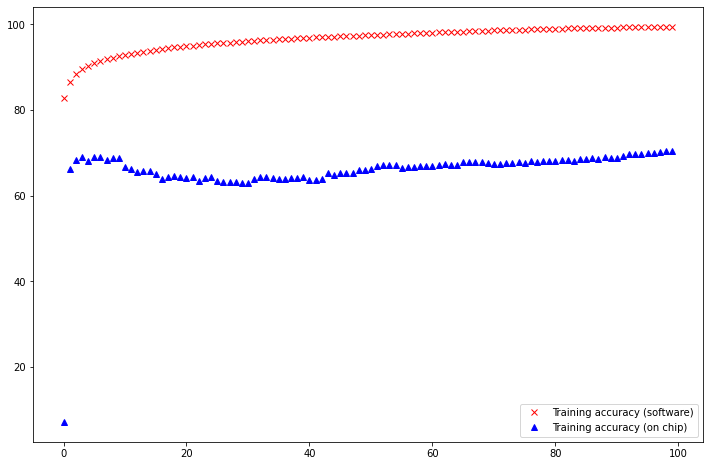

In [131]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, 'rx')
plt.plot(trainAccOnChip, 'b^')
plt.legend(["Training accuracy (software)", "Training accuracy (on chip)"])

# Plotting the accuracies for different values of $\sigma / \mu $

In [146]:
#sigmaList = [1, 0.7, 0.5, 0.3, 0.1, 0.01]
#max value of sigma = rt(0.7/3) since 99% value lie within 3xsigma^2 of mean
sigmaList = [0.3, 0.1, 0.01, 0.001, 0.0001]
mu = 0.7
vDD = 5

In [147]:
trainAccOnChipList = []
valAccOnChipList = []

In [148]:
for sigma in sigmaList:
    W1Currents = initMosParam((500, 784), mu, sigma, vDD, precision)
    b1Currents = initMosParam((500, 1), mu, sigma, vDD, precision)
    W2Currents = initMosParam((500, 500) ,mu, sigma, vDD, precision)
    b2Currents = initMosParam((500, 1), mu, sigma, vDD, precision)
    W3Currents = initMosParam((10, 500),mu, sigma, vDD, precision)
    b3Currents = initMosParam((10, 1), mu, sigma, vDD, precision)


    basePath = "D:\\perturbation_on_chip_learning\\Perturbation-techniques-in-CNNs\\weights\\"
    fileToClear = open(basePath+"W1var.txt", "w")
    fileToClear.write("")
    fileToClear.close()
    fileToClear = open(basePath+"W2var.txt", "w")
    fileToClear.write("")
    fileToClear.close()
    fileToClear = open(basePath+"W3var.txt", "w")
    fileToClear.write("")
    fileToClear.close()
    fileToClear = open(basePath+"b1var.txt", "w")
    fileToClear.write("")
    fileToClear.close()
    fileToClear = open(basePath+"b2var.txt", "w")
    fileToClear.write("")
    fileToClear.close()
    fileToClear = open(basePath+"b3var.txt", "w")
    fileToClear.write("")
    fileToClear.close()
    print("Variability transformed weights HAVE been cleared!!")


    basePath = "D:\\perturbation_on_chip_learning\\Perturbation-techniques-in-CNNs\\weights\\"
    readWriteTransform(basePath+"W1.txt", basePath+"W1var.txt", (500, 784), precision, step, discreteSteps, epochsToTrain, W1Currents)
    basePath = "D:\\perturbation_on_chip_learning\\Perturbation-techniques-in-CNNs\\weights\\"
    readWriteTransform(basePath+"b1.txt", basePath+"b1var.txt", (500, 1), precision, step, discreteSteps, epochsToTrain, b1Currents)
    basePath = "D:\\perturbation_on_chip_learning\\Perturbation-techniques-in-CNNs\\weights\\"
    readWriteTransform(basePath+"W2.txt", basePath+"W2var.txt", (500, 500), precision, step, discreteSteps, epochsToTrain, W2Currents)
    basePath = "D:\\perturbation_on_chip_learning\\Perturbation-techniques-in-CNNs\\weights\\"
    readWriteTransform(basePath+"b2.txt", basePath+"b2var.txt", (500, 1), precision, step, discreteSteps, epochsToTrain, b2Currents)
    basePath = "D:\\perturbation_on_chip_learning\\Perturbation-techniques-in-CNNs\\weights\\"
    readWriteTransform(basePath+"W3.txt", basePath+"W3var.txt", (10, 500), precision, step, discreteSteps, epochsToTrain, W3Currents)
    basePath = "D:\\perturbation_on_chip_learning\\Perturbation-techniques-in-CNNs\\weights\\"
    readWriteTransform(basePath+"b3.txt", basePath+"b3var.txt", (10, 1), precision, step, discreteSteps, epochsToTrain, b3Currents)



    basePath = "D:\\perturbation_on_chip_learning\\Perturbation-techniques-in-CNNs\\weights\\"
    fileW1var = open(basePath+"W1var.txt", 'r')
    fileb1var = open(basePath+"b1var.txt", 'r')
    fileW2var = open(basePath+"W2var.txt", 'r')
    fileb2var = open(basePath+"b2var.txt", 'r')
    fileW3var = open(basePath+"W3var.txt", 'r')
    fileb3var = open(basePath+"b3var.txt", 'r')
    trainAccOnChip = []
    valAccOnChip = []
    iter = 1
    X, Y = x_train,y_train
    for line in zip(fileW1var, fileb1var, fileW2var, fileb2var, fileW3var, fileb3var):
        W1, b1, W2, b2, W3, b3 = line
        W1 = loadFromLine(W1, (500, 784))
        b1 = loadFromLine(b1, (500,1))
        W2 = loadFromLine(W2, (500, 500))
        b2 = loadFromLine(b2, (500,1))
        W3 = loadFromLine(W3, (10, 500))
        b3 = loadFromLine(b3, (10, 1))
        #obtain training loss
        #print("Iteration {no}".format(no = iter))
        _, _, _, _, _, A3_train = forward(X, W1, b1, W2, b2, W3, b3)
        #print(f'Train Loss: {train_loss_score}')

        #obtain training accuracy
        trainScore = accuracy(predictions(A3_train), Y)
        trainAccOnChip.append(trainScore)
        #print(f'Train accuracy: {trainScore}')

        ##obtain validation loss
        _, _, _, _, _,  A3_val = forward(x_val, W1, b1, W2, b2, W3, b3)

        ##obtain validation accuracy
        val_score = accuracy(predictions(A3_val), y_val)
        valAccOnChip.append(val_score)
        #print(f'Val accuracy: {val_score}')
        print(f"Iteration {iter}  Train accuracy: {trainScore}  Val accuracy: {val_score}",  end='\r', flush=True)
        iter +=1

    trainAccOnChipList.append(trainAccOnChip)
    valAccOnChipList.append(valAccOnChip)
    fileW1var.close()
    fileb1var.close()
    fileW2var.close()
    fileb2var.close()
    fileW3var.close()
    fileb3var.close()


Variability transformed weights HAVE been cleared!!
##Fin.##ng.....Time taken = 1.31 | [████████████████████████████████████████████████████████████████████████████████████████████████████] 100/100
##Fin.##ng.....Time taken = 0.0 | [████████████████████████████████████████████████████████████████████████████████████████████████████] 100/100
##Fin.##ng.....Time taken = 0.84 | [████████████████████████████████████████████████████████████████████████████████████████████████████] 100/100
##Fin.##ng.....Time taken = 0.0 | [████████████████████████████████████████████████████████████████████████████████████████████████████] 100/100
##Fin.##ng.....Time taken = 0.02 | [████████████████████████████████████████████████████████████████████████████████████████████████████] 100/100
##Fin.##ng.....Time taken = 0.0 | [████████████████████████████████████████████████████████████████████████████████████████████████████] 100/100
Variability transformed weights HAVE been cleared!!l accuracy: 90.728571428

In [86]:
accWithEpoch = []
for i in range(epochsToTrain):
    accWithEpoch.append([i, trainAccOnChipList[0][i]])
accWithEpoch = np.array(accWithEpoch)

Text(0.5, 1.0, 'Plot of the training accuracies for different extent of variability')

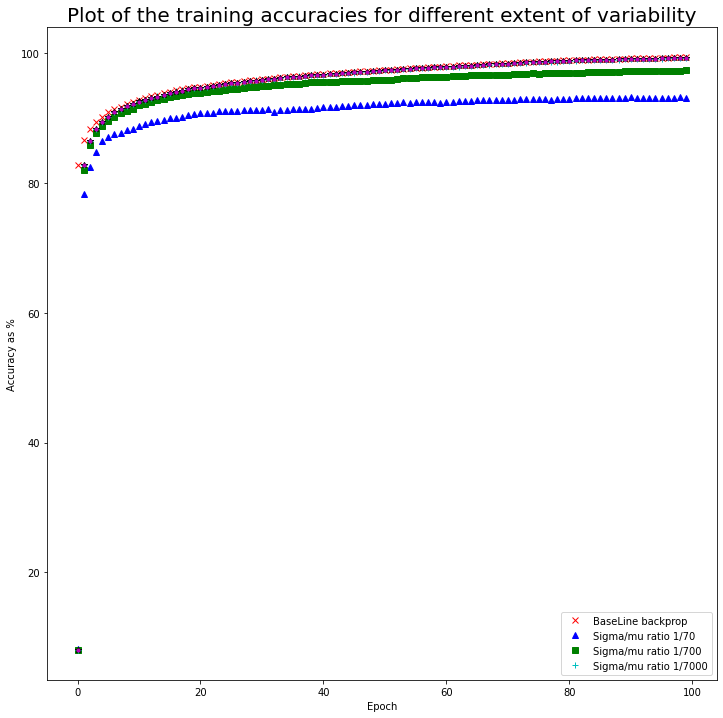

In [178]:
plt.figure(figsize=(12, 12))
plt.plot(train_acc, 'rx')
plt.plot(trainAccOnChipList[0], 'b^')
plt.plot(trainAccOnChipList[1], 'gs')
plt.plot(trainAccOnChipList[2], 'c+')
plt.plot(trainAccOnChipList[3], 'k*')
plt.plot(trainAccOnChipList[4], 'm.')

plt.xlabel("Epoch")
plt.ylabel("Accuracy as %")
#plt.legend(["BaseLine backprop", "Sigma/mu ratio 3/7", "Sigma/mu ratio 1/7", "Sigma/mu ratio 1/70", "Sigma/mu ratio 1/700", "Sigma/mu ratio 1/7000"])
plt.legend(["BaseLine backprop", "Sigma/mu ratio 1/70", "Sigma/mu ratio 1/700", "Sigma/mu ratio 1/7000"])
plt.title("Plot of the training accuracies for different extent of variability", size = 20)

Text(0.5, 1.0, 'Plot of the training accuracies for different extent of variability')

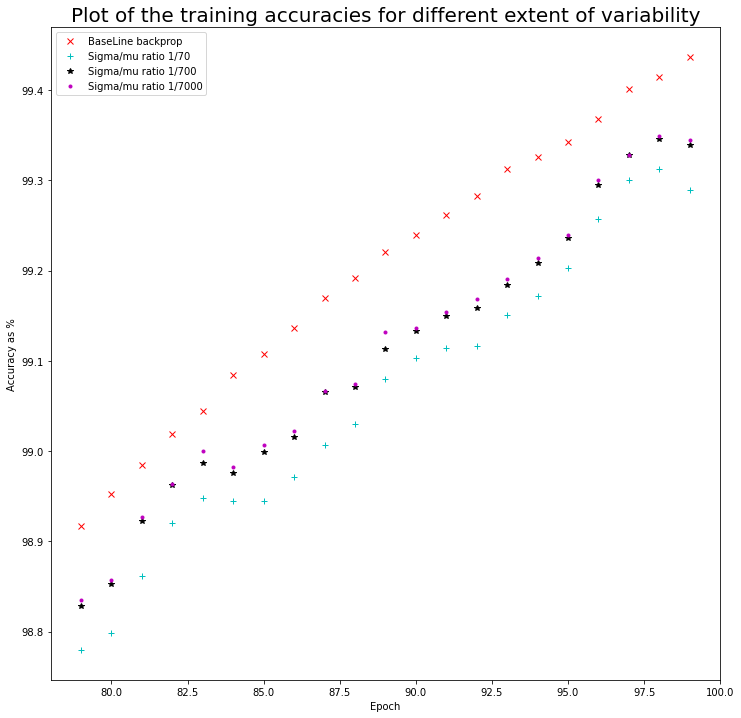

In [170]:
plt.figure(figsize=(12, 12))
xlim = range(79, 100)
plt.plot(xlim, train_acc[79:], 'rx')
#plt.plot(xlim,trainAccOnChipList[0][79:], 'b^')
#plt.plot(xlim,trainAccOnChipList[1][79:], 'gs')
plt.plot(xlim,trainAccOnChipList[2][79:], 'c+')
plt.plot(xlim,trainAccOnChipList[3][79:], 'k*')
plt.plot(xlim,trainAccOnChipList[4][79:], 'm.')

plt.xlabel("Epoch")
plt.ylabel("Accuracy as %")
#plt.legend(["BaseLine backprop", "Sigma/mu ratio 3/7", "Sigma/mu ratio 1/7", "Sigma/mu ratio 1/70", "Sigma/mu ratio 1/700", "Sigma/mu ratio 1/7000"])
plt.legend(["BaseLine backprop", "Sigma/mu ratio 1/70", "Sigma/mu ratio 1/700", "Sigma/mu ratio 1/7000"])
plt.title("Plot of the training accuracies for different extent of variability", size = 20)

Text(0.5, 1.0, 'Plot of the validation accuracies for different extent of variability')

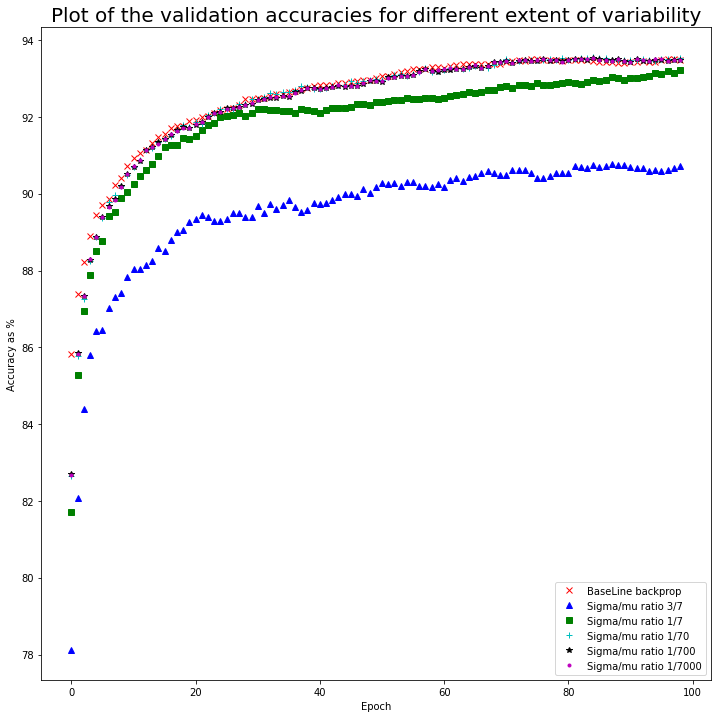

In [166]:
plt.figure(figsize=(12, 12))
plt.plot(val_acc[1:], 'rx')
plt.plot(valAccOnChipList[0][1:], 'b^')
plt.plot(valAccOnChipList[1][1:], 'gs')
plt.plot(valAccOnChipList[2][1:], 'c+')
plt.plot(valAccOnChipList[3][1:], 'k*')
plt.plot(valAccOnChipList[4][1:], 'm.')

plt.xlabel("Epoch")
plt.ylabel("Accuracy as %")
plt.legend(["BaseLine backprop", "Sigma/mu ratio 3/7", "Sigma/mu ratio 1/7", "Sigma/mu ratio 1/70", "Sigma/mu ratio 1/700", "Sigma/mu ratio 1/7000"])
plt.title("Plot of the validation accuracies for different extent of variability", size = 20)

# Forward pass and the inference on-chip

In [192]:
answerToClear = input("Do you want to clear the weights of the model from the text files? ")
if answerToClear.lower().strip()=='yes':
    basePath = "D:\\perturbation_on_chip_learning\\Perturbation-techniques-in-CNNs\\weights\\"
    fileToClear = open(basePath+"W1.txt", "w")
    fileToClear.write("")
    fileToClear.close()
    fileToClear = open(basePath+"W2.txt", "w")
    fileToClear.write("")
    fileToClear.close()
    fileToClear = open(basePath+"W3.txt", "w")
    fileToClear.write("")
    fileToClear.close()
    fileToClear = open(basePath+"b1.txt", "w")
    fileToClear.write("")
    fileToClear.close()
    fileToClear = open(basePath+"b2.txt", "w")
    fileToClear.write("")
    fileToClear.close()
    fileToClear = open(basePath+"b3.txt", "w")
    fileToClear.write("")
    fileToClear.close()
    print("Weights of the model HAVE been cleared!!")
else:
    print("Weights of the model have NOT been cleared. You can use those weights!!")

Weights of the model HAVE been cleared!!


In [189]:
#have to change with different number of layers
def params_init():

  #np.random.seed(2)
  W1 = np.random.rand(500,784) - 0.5
  b1 = np.random.rand(500,1) - 0.5
  W2 = np.random.rand(500,500) - 0.5
  b2 = np.random.rand(500,1) - 0.5
  W3 = np.random.rand(10,500) - 0.5 
  b3 = np.random.rand(10,1) - 0.5
  #W4 = np.random.rand(50,200) - 0.5   
  #b4 = np.random.rand(50,1) - 0.5    
  #W5 = np.random.rand(10,50) - 0.5  
  #b5 = np.random.rand(10,1) - 0.5    
  print("Params Initialised")

  return (W1, b1, W2, b2, W3, b3)


#have to change with different number of layers
def forward(x_train, W1, b1, W2, b2, W3, b3):
  #print("Entered FP")
  Z1 = np.matmul(W1,x_train) + b1 #W1 is 50*784, x_train is 748*m, Z1 is 50*m
  A1 = relu(Z1)

  Z2 = np.matmul(W2,A1) + b2 
  A2 = relu(Z2)

  Z3 = np.matmul(W3,A2) + b3
  A3 = softmax(Z3)
  
  #Z4 = np.matmul(W4,A3) + b4
  #A4 = relu(Z4)

  #Z5 = np.matmul(W5,A4) + b5
  #A5 = softmax(Z5)

  #W2 is 10*50, A1 is 50*m
  # print(np.exp(Z2))
  # print(np.sum(np.exp(Z2)))

  #A2 is 10*m, final predictions
  # print("Fp Done")

  return Z1, A1, Z2, A2, Z3, A3


def relu(x):
   return np.maximum(x,0)


def softmax(Z):
  return np.exp(Z) / np.sum(np.exp(Z),0)


def relu_d(x):
  return x>0


def one_hot_encoding(y):
  shape = (y.shape[0], 10)
  one_hot = np.zeros(shape)
  rows = np.arange(y.size)
  one_hot[rows, y] = 1
  return one_hot.T


#have to change with different number of layers
def backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, y):
  # print("Entered Backprop")
  m = y.shape[0] #m is the number of training examples
  Y = one_hot_encoding(y)

  dZ3 = (A3 - Y)
  
  dW3 = 1/m*np.matmul(dZ3,A2.T)

  db3 = 1/m*np.sum(dZ3, axis=1)

  dZ2 = np.matmul(W3.T, dZ3)*relu_d(Z2) #W2 is 10*50, dZ2 = 10*m, dZ1 = 50*m

  dW2 = 1/m*np.matmul(dZ2,A1.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db2 = 1/m*np.sum(dZ2, axis=1) #db1 is 50*1

  dZ1 = np.matmul(W2.T, dZ2)*relu_d(Z1) #W2 is 10*50, dZ2 = 10*m, dZ1 = 50*m

  dW1 = 1/m*np.matmul(dZ1,X.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db1 = 1/m*np.sum(dZ1, axis = 1) #db1 is 50*1


  return dW1, db1, dW2, db2, dW3, db3


#have to change with different number of layers
def param_update(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, lr):

  #updates the parameters based on backpropogation

  W1 = W1 - lr*dW1
  b1 = b1 - lr*(db1.reshape(b1.shape))
  W2 = W2 - lr*dW2
  b2 = b2 - lr*(db2.reshape(b2.shape))
  W3 = W3 - lr*dW3
  b3 = b3 - lr*(db3.reshape(b3.shape))
  #W4 = W4 - lr*dW4
  #b4 = b4 - lr*db4

  return W1, b1, W2, b2, W3, b3


#have to change with different number of layers
def batch_grad_descentFPOC(X,Y,iter, lr, mu, sigma, vDD, precision, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []


  W1Currents = initMosParam((500, 784), mu, sigma, vDD, precision)
  b1Currents = initMosParam((500, 1), mu, sigma, vDD, precision)
  W2Currents = initMosParam((500, 500) ,mu, sigma, vDD, precision)
  b2Currents = initMosParam((500, 1), mu, sigma, vDD, precision)
  W3Currents = initMosParam((10, 500),mu, sigma, vDD, precision)
  b3Currents = initMosParam((10, 1), mu, sigma, vDD, precision)

  W1, b1, W2, b2, W3, b3 = params_init()
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)


  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0


    #storing the weights:
    start = time.time()
    basePath = "D:\\perturbation_on_chip_learning\\Perturbation-techniques-in-CNNs\\weights\\"
    saveText(basePath+"W1.txt", W1)
    saveText(basePath+"W2.txt", W2)
    saveText(basePath+"W3.txt", W3)
    saveText(basePath+"b1.txt", b1)
    saveText(basePath+"b2.txt", b2)
    saveText(basePath+"b3.txt", b3)
    end = time.time()
    print("###Saving weights : {time}".format(time = end - start))


    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes 

      startin = time.time()
      W1varoc = weightTransformWithVariability(W1, W1Currents, precision, step, discreteSteps)
      b1varoc = weightTransformWithVariability(b1, b1Currents, precision, step, discreteSteps)
      W2varoc = weightTransformWithVariability(W2, W2Currents, precision, step, discreteSteps)
      b2varoc = weightTransformWithVariability(b2, b2Currents, precision, step, discreteSteps)
      W3varoc = weightTransformWithVariability(W3, W3Currents, precision, step, discreteSteps)
      b3varoc = weightTransformWithVariability(b3, b3Currents, precision, step, discreteSteps)
      endin = time.time()
      print(f"#Fin processing weights {endin-startin}                                                     ", end = "\r", flush= True)


      Z1, A1, Z2, A2, Z3, A3 = forward(X1, W1varoc, b1varoc, W2varoc, b2varoc, W3varoc, b3varoc) 

      dW1, db1, dW2, db2, dW3, db3 = backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X1, Y1)


      W1, b1, W2, b2, W3, b3 = param_update(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, lr = lr)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _, _, _, A3_train = forward(X, W1, b1, W2, b2, W3, b3)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A3_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _, _, _,  A3_val = forward(x_val, W1, b1, W2, b2, W3, b3)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A3_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return W1, b1, W2, b2, W3, b3, train_acc, val_acc, train_loss, val_loss, sum_weights




def grad_descent(X,Y,iter, lr, print_op, decay_factor=0):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  mu = 1
  sigma = 0.4

  W1, b1, W2, b2, W3, b3 = params_init()
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)


  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0
    X1, Y1 = X.T, Y
    X1 = X1.T #take transpose to match the sizes

    Z1, A1, Z2, A2, Z3, A3 = forward(X1, W1, b1, W2, b2, W3, b3) 

    dW1, db1, dW2, db2, dW3, db3 = backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X1, Y1)

    W1, b1, W2, b2, W3, b3 = param_update(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, lr = lr, factor = decay_factor)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _, _, _, A3_train = forward(X, W1, b1, W2, b2, W3, b3)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A3_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _, _, _,  A3_val = forward(x_val, W1, b1, W2, b2, W3, b3)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A3_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return W1, b1, W2, b2, W3, b3, train_acc, val_acc, train_loss, val_loss, sum_weights


def predictions(A):
  #argmax returns the index of maximum value, we will feed the sigmoid output to this function 
  return np.argmax(A,0)


def accuracy(A,Y):
  #this will compare the predicted output to the ground truth
  return np.sum(A == Y)/Y.shape[0]*100


In [190]:
answerToTrain = input("Do you want to train the model again? : ")
if answerToTrain.strip().lower()=='yes':
    W1, b1, W2, b2, W3, b3, train_acc, val_acc, train_loss, val_loss, sum_weights = batch_grad_descentFPOC(x_train,y_train,epochsToTrain, 0.01, 0.7, 0.1, 5, precision, print_op=1)
    

Params Initialised
###Saving weights : 1.8293569087982178
Iteration: 1ing weights 0.25118184089660645                                                     
Train accuracy: 83.35396825396826
Val accuracy: 82.8
###Saving weights : 1.632204532623291
Iteration: 2ing weights 0.22974252700805664                                                     
Train accuracy: 86.83015873015873
Val accuracy: 85.71428571428571
###Saving weights : 1.7038111686706543
Iteration: 3ing weights 0.2767148017883301                                                      
Train accuracy: 88.63492063492063
Val accuracy: 87.5142857142857
###Saving weights : 1.7156343460083008
Iteration: 4ing weights 0.26787400245666504                                                     
Train accuracy: 89.61746031746031
Val accuracy: 88.52857142857142
###Saving weights : 1.7028751373291016
Iteration: 5ing weights 0.344832181930542                                                       
Train accuracy: 90.44126984126984
Val accuracy: 89.1

In [193]:
W1, b1, W2, b2, W3, b3, trainAccClean, valAccClean, train_loss_clean, val_loss_clean, sum_weights = batch_grad_descent(x_train,y_train,epochsToTrain, 0.01,1)

Params Initialised
###Saving weights : 1.7402000427246094
Iteration: 1
Train accuracy: 83.32063492063492
Val accuracy: 83.02857142857142
###Saving weights : 1.690758228302002
Iteration: 2
Train accuracy: 87.0015873015873
Val accuracy: 86.35714285714286
###Saving weights : 2.0906105041503906
Iteration: 3
Train accuracy: 88.79523809523809
Val accuracy: 88.0
###Saving weights : 2.401162624359131
Iteration: 4
Train accuracy: 89.9015873015873
Val accuracy: 89.05714285714285
###Saving weights : 1.7803966999053955
Iteration: 5
Train accuracy: 90.67619047619047
Val accuracy: 89.72857142857143
###Saving weights : 1.9396252632141113
Iteration: 6
Train accuracy: 91.24285714285715
Val accuracy: 90.17142857142856
###Saving weights : 1.5863428115844727
Iteration: 7
Train accuracy: 91.77301587301588
Val accuracy: 90.44285714285715
###Saving weights : 1.550123691558838
Iteration: 8
Train accuracy: 92.23333333333333
Val accuracy: 90.8
###Saving weights : 1.545351505279541
Iteration: 9
Train accuracy: 9

Text(0.5, 1.0, 'FP done on chip, everything else done in software, mu=0.7, sigma=0.1')

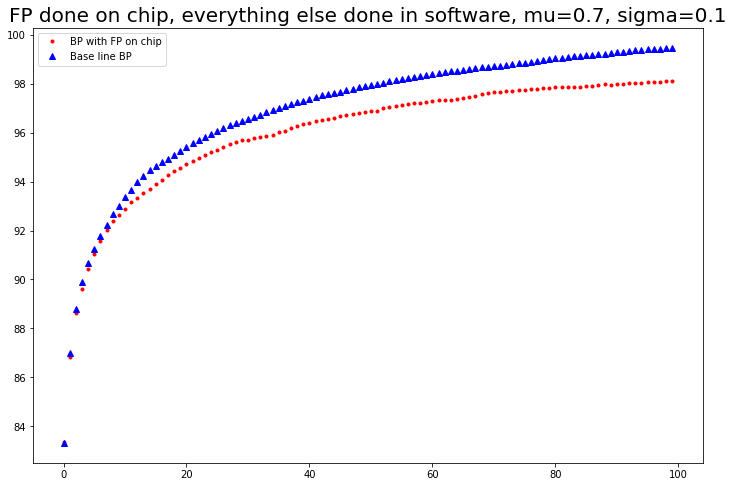

In [198]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, 'r.')
plt.plot(trainAccClean, 'b^')
plt.legend(["BP with FP on chip", "Base line BP"])
plt.title("FP done on chip, everything else done in software, mu=0.7, sigma=0.1", size=20)

In [1]:
from multiprocessing import Pool

In [2]:
def f(x):
    return x*x


with Pool(5) as p:
    print(p.map(f, [1, 2, 3]))

In [2]:
from os import getpid

def double(i):
    print("I'm process", getpid())
    return i * 2

if __name__ == '__main__':
    with Pool(1) as pool:
        result = pool.map(double, [1, 2, 3, 4, 5])
        print(result)

In [1]:
import multiprocessing as mp

def f(x):
    return x+1

def main():
    ar = [1,2,3,4,5]
    pool = mp.Pool(processes=4)
    print(pool.map(f, ar))

if __name__ == '__main__':
    main()

In [1]:
import multiprocessing

multiprocessing.cpu_count()

12